<a href="https://colab.research.google.com/github/hsinghal11/colab/blob/main/Lab4_ai_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install datasets scikit-learn numpy scipy matplotlib

In [14]:
# Import necessary libraries
from datasets import load_dataset
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import entropy
import matplotlib.pyplot as plt
import random

In [15]:
# Load the MNIST dataset
mnist_dataset = load_dataset('mnist')

# Function to preprocess the dataset
def preprocess_data(dataset):
    images = np.array([np.array(image) for image in dataset['image']])
    labels = np.array(dataset['label'])
    images = images / 255.0  # Normalize pixel values to [0, 1]
    return images, labels

# Preprocess the training and testing datasets
train_images, train_labels = preprocess_data(mnist_dataset['train'])
test_images, test_labels = preprocess_data(mnist_dataset['test'])

# Flatten each image into a vector of 784 features
train_images = train_images.reshape(train_images.shape[0], -1)  # Shape: (60000, 784)
test_images = test_images.reshape(test_images.shape[0], -1)     # Shape: (10000, 784)

# Randomly select an initial labeled dataset of 200 samples
random.seed(42)
initial_labeled_indices = random.sample(range(train_images.shape[0]), 200)
initial_labeled_images = train_images[initial_labeled_indices]
initial_labeled_labels = train_labels[initial_labeled_indices]

# Generate the unlabeled pool
unlabeled_pool_indices = list(set(range(train_images.shape[0])) - set(initial_labeled_indices))
unlabeled_pool_images = train_images[unlabeled_pool_indices]
unlabeled_pool_labels = train_labels[unlabeled_pool_indices]  # These labels are hidden in practice

In [16]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the initial labeled dataset
rf_classifier.fit(initial_labeled_images, initial_labeled_labels)

# Copy the initial labeled dataset and unlabeled pool
labeled_images = initial_labeled_images.copy()
labeled_labels = initial_labeled_labels.copy()
unlabeled_images = unlabeled_pool_images.copy()
unlabeled_labels = unlabeled_pool_labels.copy()

# Active learning loop for 20 iterations
accuracies_random = []  # Store accuracies for random sampling
for iteration in range(20):
    # Randomly select a sample from the unlabeled pool
    random_index = np.random.choice(len(unlabeled_images))
    selected_image = unlabeled_images[random_index]
    selected_label = unlabeled_labels[random_index]

    # Add the selected sample to the labeled dataset
    labeled_images = np.vstack([labeled_images, selected_image])
    labeled_labels = np.append(labeled_labels, selected_label)

    # Remove the selected sample from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, random_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, random_index)

    # Retrain the model
    rf_classifier.fit(labeled_images, labeled_labels)

    # Evaluate the model on the test set
    accuracy = accuracy_score(test_labels, rf_classifier.predict(test_images))
    accuracies_random.append(accuracy)  # Save accuracy
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy:.4f}")

Iteration 1: Accuracy = 0.7726
Iteration 2: Accuracy = 0.7590
Iteration 3: Accuracy = 0.7719
Iteration 4: Accuracy = 0.7677
Iteration 5: Accuracy = 0.7697
Iteration 6: Accuracy = 0.7571
Iteration 7: Accuracy = 0.7550
Iteration 8: Accuracy = 0.7624
Iteration 9: Accuracy = 0.7514
Iteration 10: Accuracy = 0.7596
Iteration 11: Accuracy = 0.7688
Iteration 12: Accuracy = 0.7659
Iteration 13: Accuracy = 0.7623
Iteration 14: Accuracy = 0.7682
Iteration 15: Accuracy = 0.7741
Iteration 16: Accuracy = 0.7666
Iteration 17: Accuracy = 0.7573
Iteration 18: Accuracy = 0.7584
Iteration 19: Accuracy = 0.7635
Iteration 20: Accuracy = 0.7633


In [17]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model on the initial labeled dataset
rf_classifier.fit(initial_labeled_images, initial_labeled_labels)

def calculate_entropy(probabilities):
    """
    Calculate entropy for a given probability distribution.
    :param probabilities: A list or array of probabilities.
    :return: Entropy value.
    """
    entropy_value = 0
    for p in probabilities:
        if p > 0:  # Avoid log(0) which is undefined
            entropy_value -= p * np.log2(p)
    return entropy_value

# Copy the initial labeled dataset and unlabeled pool
labeled_images = initial_labeled_images.copy()
labeled_labels = initial_labeled_labels.copy()
unlabeled_images = unlabeled_pool_images.copy()
unlabeled_labels = unlabeled_pool_labels.copy()

# Active learning loop for 20 iterations
accuracies_uncertainty = []  # Store accuracies for uncertainty sampling
for iteration in range(20):
    # Compute label probabilities for the unlabeled pool
    probabilities = rf_classifier.predict_proba(unlabeled_images)

    # Compute label entropy for each sample
    label_entropies = []
    for prob in probabilities:
        entropy_value = calculate_entropy(prob)  # Use custom entropy function
        label_entropies.append(entropy_value)

    # Select the sample with the highest label entropy
    uncertain_index = np.argmax(label_entropies)
    selected_image = unlabeled_images[uncertain_index]
    selected_label = unlabeled_labels[uncertain_index]

    # Add the selected sample to the labeled dataset
    labeled_images = np.vstack([labeled_images, selected_image])
    labeled_labels = np.append(labeled_labels, selected_label)

    # Remove the selected sample from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, uncertain_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, uncertain_index)

    # Retrain the model
    rf_classifier.fit(labeled_images, labeled_labels)

    # Evaluate the model on the test set
    accuracy = accuracy_score(test_labels, rf_classifier.predict(test_images))
    accuracies_uncertainty.append(accuracy)  # Save accuracy
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy:.4f}")

Iteration 1: Accuracy = 0.7729
Iteration 2: Accuracy = 0.7657
Iteration 3: Accuracy = 0.7679
Iteration 4: Accuracy = 0.7769
Iteration 5: Accuracy = 0.7821
Iteration 6: Accuracy = 0.7736
Iteration 7: Accuracy = 0.7756
Iteration 8: Accuracy = 0.7738
Iteration 9: Accuracy = 0.7712
Iteration 10: Accuracy = 0.7769
Iteration 11: Accuracy = 0.7816
Iteration 12: Accuracy = 0.7714
Iteration 13: Accuracy = 0.7765
Iteration 14: Accuracy = 0.7830
Iteration 15: Accuracy = 0.7821
Iteration 16: Accuracy = 0.7803
Iteration 17: Accuracy = 0.7780
Iteration 18: Accuracy = 0.7823
Iteration 19: Accuracy = 0.7765
Iteration 20: Accuracy = 0.7794


In [18]:
# Initialize a committee of 5 Random Forest models
committee = [RandomForestClassifier(random_state=42 + i) for i in range(5)]

# Train each model on the initial labeled dataset
for model in committee:
    model.fit(initial_labeled_images, initial_labeled_labels)

# Copy the initial labeled dataset and unlabeled pool
labeled_images = initial_labeled_images.copy()
labeled_labels = initial_labeled_labels.copy()
unlabeled_images = unlabeled_pool_images.copy()
unlabeled_labels = unlabeled_pool_labels.copy()

# Custom function to calculate entropy
def calculate_entropy(probabilities):
    """
    Calculate entropy for a given probability distribution.
    :param probabilities: A list or array of probabilities.
    :return: Entropy value.
    """
    entropy_value = 0
    for p in probabilities:
        if p > 0:  # Avoid log(0) which is undefined
            entropy_value -= p * np.log2(p)
    return entropy_value

# Active learning loop for 20 iterations
accuracies_qbc = []  # Store accuracies for query-by-committee
for iteration in range(20):
    # Compute predictions for each unlabeled sample from all committee members
    predictions = np.array([model.predict(unlabeled_images) for model in committee])

    # Compute vote entropy for each sample
    vote_entropies = []
    for i in range(len(unlabeled_images)):
        votes = predictions[:, i]  # Predictions from all committee members for the i-th sample
        unique_labels, counts = np.unique(votes, return_counts=True)
        probabilities = counts / len(committee)  # Probability distribution of votes
        vote_entropy = calculate_entropy(probabilities)  # Calculate entropy manually
        vote_entropies.append(vote_entropy)

    # Select the sample with the highest vote entropy
    uncertain_index = np.argmax(vote_entropies)
    selected_image = unlabeled_images[uncertain_index]
    selected_label = unlabeled_labels[uncertain_index]

    # Add the selected sample to the labeled dataset
    labeled_images = np.vstack([labeled_images, selected_image])
    labeled_labels = np.append(labeled_labels, selected_label)

    # Remove the selected sample from the unlabeled pool
    unlabeled_images = np.delete(unlabeled_images, uncertain_index, axis=0)
    unlabeled_labels = np.delete(unlabeled_labels, uncertain_index)

    # Retrain all models in the committee
    for model in committee:
        model.fit(labeled_images, labeled_labels)

    # Evaluate the committee's accuracy on the test set (using the first model)
    accuracy = accuracy_score(test_labels, committee[0].predict(test_images))
    accuracies_qbc.append(accuracy)  # Save accuracy
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy:.4f}")

Iteration 1: Accuracy = 0.7711
Iteration 2: Accuracy = 0.7620
Iteration 3: Accuracy = 0.7630
Iteration 4: Accuracy = 0.7626
Iteration 5: Accuracy = 0.7662
Iteration 6: Accuracy = 0.7754
Iteration 7: Accuracy = 0.7728
Iteration 8: Accuracy = 0.7696
Iteration 9: Accuracy = 0.7739
Iteration 10: Accuracy = 0.7667
Iteration 11: Accuracy = 0.7715
Iteration 12: Accuracy = 0.7671
Iteration 13: Accuracy = 0.7683
Iteration 14: Accuracy = 0.7657
Iteration 15: Accuracy = 0.7697
Iteration 16: Accuracy = 0.7816
Iteration 17: Accuracy = 0.7781
Iteration 18: Accuracy = 0.7863
Iteration 19: Accuracy = 0.7834
Iteration 20: Accuracy = 0.7904


In [19]:
# Print final accuracies for all strategies
print(f"Final Accuracy (Random Sampling): {accuracies_random[-1]:.4f}")
print(f"Final Accuracy (Uncertainty Sampling): {accuracies_uncertainty[-1]:.4f}")
print(f"Final Accuracy (Query-by-Committee): {accuracies_qbc[-1]:.4f}")

Final Accuracy (Random Sampling): 0.7633
Final Accuracy (Uncertainty Sampling): 0.7794
Final Accuracy (Query-by-Committee): 0.7904


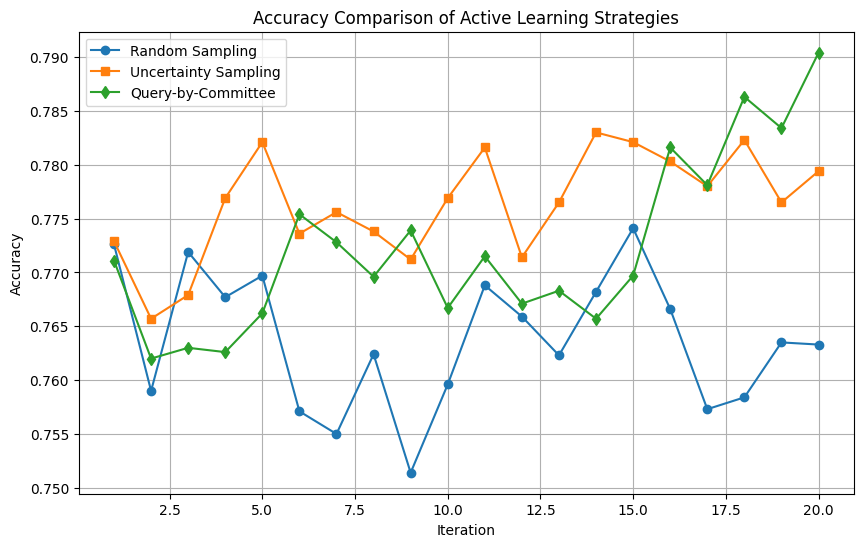

In [23]:
# Plot the accuracies over iterations
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), accuracies_random, label="Random Sampling", marker = "o")
plt.plot(range(1, 21), accuracies_uncertainty, label="Uncertainty Sampling", marker='s')
plt.plot(range(1, 21), accuracies_qbc, label="Query-by-Committee", marker='d')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Active Learning Strategies")
plt.legend()
plt.grid(True)
plt.show()